In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# データセットのダウンロード

In [17]:
!pip install -q kaggle
# /root/.kaggleにkaggle.jsonを移動する
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [18]:
!kaggle datasets download -d nitishabharathi/scene-classification

scene-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [19]:
!rm -rf data 
!rm -rf /content/train-scene classification

In [ ]:
! yes | unzip -q /content/scene-classification.zip

# データセットを分ける

In [21]:
import shutil
import os

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import sklearn 
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

In [22]:
train_df = pd.read_csv('/content/train-scene classification/train.csv')

classes = {0:'0_Buildings', 1:'1_Forests', 2:'2_Glacier', 3:'3_Mountains', 4:'4_Sea', 5:'5_Street'}

train_df['label'] = train_df['label'].map(classes)
display(train_df.head())
display(train_df['label'].value_counts())
print(f'len: {len(train_df)}')

,image_name,label
0,0.jpg,0_Buildings
1,1.jpg,4_Sea
2,2.jpg,5_Street
3,4.jpg,0_Buildings
4,7.jpg,4_Sea


3_Mountains    3037
2_Glacier      2957
5_Street       2883
4_Sea          2784
1_Forests      2745
0_Buildings    2628
Name: label, dtype: int64

len: 17034


In [23]:
# 学習,テストデータに分割
train, valid_test = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True, stratify=train_df['label']) # 層化抽出する
valid, test = train_test_split(valid_test, test_size=(0.5), random_state=42, shuffle=True, stratify=valid_test['label']) # 層化抽出する

In [24]:
# クラスごとにデータのディレクトリを分ける
for dir in ['data', 'data/train', 'data/valid', 'data/test']:
    os.makedirs(dir, exist_ok=True)

for v in classes.values():
    os.makedirs(f'/content/data/train/{v}', exist_ok=True)
    os.makedirs(f'/content/data/valid/{v}', exist_ok=True)
    os.makedirs(f'/content/data/test/{v}', exist_ok=True)

for img_path, label in zip(train['image_name'].to_list(), train['label'].to_list()):
    _ = shutil.move(f'/content/train-scene classification/train/{img_path}', f'/content/data/train/{label}/')

for img_path, label in zip(valid['image_name'].to_list(), valid['label'].to_list()):
    _ = shutil.move(f'/content/train-scene classification/train/{img_path}', f'/content/data/valid/{label}/')

for img_path, label in zip(test['image_name'].to_list(), test['label'].to_list()):
    _ = shutil.move(f'/content/train-scene classification/train/{img_path}', f'/content/data/test/{label}/')

# 分割できてるか確認

In [25]:
import cv2
from google.colab.patches import cv2_imshow

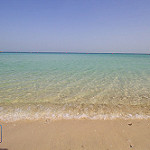

In [26]:
#画像のインポート
image = cv2.imread('/content/data/train/4_Sea/10016.jpg')
cv2_imshow(image)

# モデルの学習

In [27]:
#!kaggle datasets download -d prashantchandel1097/efficientnetkerasapplications
#!unzip /content/efficientnetkerasapplications.zip

In [28]:
#!pip install Keras_Applications-1.0.8-py3-none-any.whl
#!pip install efficientnet-1.1.1-py3-none-any.whl

In [29]:
#! pip install -U git+https://github.com/qubvel/efficientnet

In [30]:
#import efficientnet.tfkeras as efn

In [31]:
# CONFIG
EPOCHS = 30
BATCH_SIZE = 32 
IMAGE_SIZE = [150, 150]
LR = 0.0001
VERBOSE = 2
N_CLASSES = 6
SEED = 42

In [32]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

def get_lr_callback():
    lr_start   = 0.000001
    lr_max     = 0.000005 * BATCH_SIZE
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max    
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    return lr_callback


def get_model():
    trained_model = keras.applications.MobileNetV2(weights='imagenet', input_shape=(*IMAGE_SIZE, 3), include_top=False)
    inputs = keras.Input(shape=(*IMAGE_SIZE, 3))
    x = trained_model(inputs)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(N_CLASSES, activation='softmax')(x)
    model = keras.Model(inputs, outputs)

    opt = tf.keras.optimizers.Adam(learning_rate = LR)

    model.compile(
        optimizer = opt,
        loss = [keras.losses.CategoricalCrossentropy()],
        metrics = [keras.metrics.CategoricalAccuracy()]
        ) 
    return model


def train_and_evaluate():

    # Seed everything
    seed_everything(SEED)
    
    print('\n')
    print('-'*50)

    K.clear_session()
    model = get_model()
    # Model checkpoint
    checkpoint = keras.callbacks.ModelCheckpoint(f'MobileNetV2_{IMAGE_SIZE[0]}_{SEED}'+'.h5', 
                                                    monitor = 'val_loss', 
                                                    verbose = VERBOSE, 
                                                    save_best_only = False, # モデルの構造を保存する
                                                    save_weights_only = True, 
                                                    mode = 'min')

    history = model.fit_generator(train_it,
                        steps_per_epoch = train_it.samples/train_it.batch_size,
                        epochs = EPOCHS,
                        callbacks = [checkpoint, get_lr_callback()], 
                        validation_data = valid_it,
                        validation_steps=len(valid)/BATCH_SIZE,
                        verbose = VERBOSE)
        
    return model, history

In [33]:
# data augmentaion

datagen = ImageDataGenerator(
        #rescale=1./255, 
        #shear_range=5, #せん断する際の角度の範囲
        rotation_range=10,  # 整数．画像をランダムに回転する回転範囲．
        width_shift_range=0.1,  # 浮動小数点数（横幅に対する割合）．ランダムに水平シフトする範囲
        height_shift_range=0.1,  # 浮動小数点数（縦幅に対する割合）．ランダムに垂直シフトする範囲
        zoom_range=0.1, 
        horizontal_flip=True,  # 水平方向に入力をランダムに反転
        #vertical_flip=True, # 垂直方向に入力をランダムに反転
        fill_mode='nearest'
        )

test_datagen = ImageDataGenerator(
            #rescale=1./255
            )

train_data_path = "data/train/"
valid_data_path = "data/valid/"
test_data_path = "data/test/"

# 訓練データをフォルダから読み込む
# .flow_from_directory() ディレクトリへのパスを受け取り，拡張/正規化したデータのバッチを生成
train_it = datagen.flow_from_directory(train_data_path, # パス
                                       target_size=(150, 150), # リサイズする画像のサイズ 
                                       color_mode='rgb', # "grayscale"：白黒、"rbg"：カラー
                                       class_mode="categorical") 
                                       # "categorical"は2次元のone-hotにエンコード化されたラベル、"binary"は1次元の2値ラベル
                                       # "sparse"は1次元の整数ラベル，"input"は入力画像と同じ画像

# テストデータをフォルダから読み込む
valid_it = test_datagen.flow_from_directory(valid_data_path,
                                      target_size=(150, 150), 
                                      color_mode='rgb', 
                                      class_mode="categorical")

# テストデータをフォルダから読み込む
test_it = test_datagen.flow_from_directory(test_data_path,
                                      target_size=(150, 150), 
                                      color_mode='rgb', 
                                      class_mode="categorical")

Found 13627 images belonging to 6 classes.
Found 1703 images belonging to 6 classes.
Found 1704 images belonging to 6 classes.


In [34]:
# 結果のプロット
def plot_result(history):
   acc = history.history['categorical_accuracy']
   val_acc = history.history['val_categorical_accuracy']
   loss = history.history['loss']
   val_loss = history.history['val_loss']

   plt.plot(range(1, EPOCHS), acc[1:], 'bo', label='Training acc')
   plt.plot(range(1, EPOCHS), val_acc[1:], 'b', label='Validation acc')
   plt.title('Training and Validation acc')
   plt.legend()

   plt.figure()

   plt.plot(range(1, EPOCHS), loss[1:], 'bo', label='Training loss')
   plt.plot(range(1, EPOCHS), val_loss[1:], 'b', label='Validation loss')
   plt.title('Training and Validation loss')
   plt.legend()  

   plt.show()

In [35]:
model, history = train_and_evaluate()



--------------------------------------------------
9412608/9406464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
425/425 - 112s - loss: 1.7884 - categorical_accuracy: 0.3065 - val_loss: 1.9216 - val_categorical_accuracy: 0.3306

Epoch 00001: saving model to MobileNetV2_150_42.h5
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 3.28e-05.
425/425 - 76s - loss: 0.5320 - categorical_accuracy: 0.8174 - val_loss: 0.4718 - val_categorical_accuracy: 0.8503

Epoch 00002: saving model to MobileNetV2_150_42.h5
Epoch 3/30

Epoch 00003: LearningRateScheduler reducing learning rate to 6.46e-05.
425/425 - 76s - loss: 0.2973 - categorical_accuracy: 0.8946 - val_loss: 0.3468 - val_categorical_accuracy: 0.8808

Epoch 00003: saving model to MobileNetV2_150_42.h5
Epoch 4/30

Epoch 00004: LearningRateScheduler reducing learning rate to 9.64e-05.
425/425 - 76s - loss: 0.2402 - categorical_accuracy: 0.9132 - val_loss: 0.2428 - val_categorical_accuracy: 0.9137

Epoch 00004: saving model to MobileNetV2_150_42.h5
Epoch 

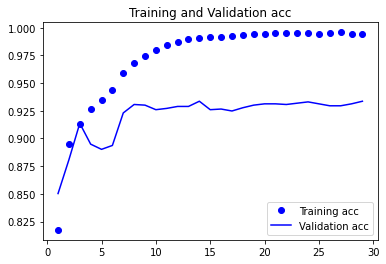

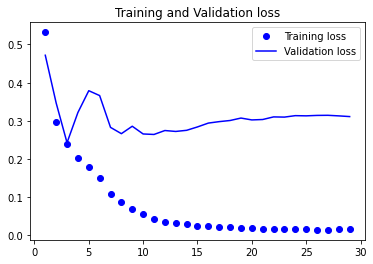

In [36]:
plot_result(history)

In [37]:
test_loss, test_acc = model.evaluate_generator(test_it, steps=len(test)/BATCH_SIZE)
print('test acc: ', test_acc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc:  0.9348591566085815


# 推論のテスト

In [38]:
# CONFIG
IMAGE_SIZE = [150, 150]
VERBOSE = 2
N_CLASSES = 6
SEED = 42

In [40]:
# 保存したモデルのロード
def load_weights(weights_path):
    model = keras.applications.MobileNetV2(weights=None, input_shape=(*IMAGE_SIZE, 3), include_top=False)
    inputs = keras.Input(shape=(*IMAGE_SIZE, 3))
    x = model(inputs)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(N_CLASSES, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.load_weights(weights_path)
    return model

load_model = load_weights('/content/drive/MyDrive/大学/4年前期/複合現実感/MobileNetV2_150_42.h5')

In [41]:
from keras.preprocessing import image

In [42]:
#画像のインポート
img = image.load_img('/content/data/test/4_Sea/10068.jpg', target_size=(150, 150))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

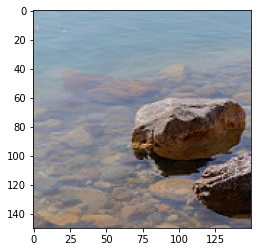

In [43]:
plt.imshow(img[0]/255.)
#plt.show()

In [44]:
%%time
# 推論実行
classifications = load_model.predict(img)
# 推論結果表示
print(classes[np.argmax(np.squeeze(classifications))])

4_Sea
CPU times: user 906 ms, sys: 11.1 ms, total: 917 ms
Wall time: 1.22 s


# モデルの構造を含めて保存

In [45]:
# モデルを保存
load_model.save('/content/drive/MyDrive/大学/4年前期/複合現実感/saved_model', save_format='tf')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/大学/4年前期/複合現実感/saved_model/assets


In [46]:
# モデルをロード
load_model = tf.keras.models.load_model('/content/drive/MyDrive/大学/4年前期/複合現実感/saved_model')

In [47]:
%%time
# 推論実行
classifications = load_model.predict(img)
# 推論結果表示
print(classes[np.argmax(np.squeeze(classifications))])

4_Sea
CPU times: user 617 ms, sys: 11 ms, total: 628 ms
Wall time: 621 ms


# ONNXに変換

In [48]:
!pip install tf2onnx

     |████████████████████████████████| 378kB 7.5MB/s 
     |████████████████████████████████| 12.2MB 259kB/s 


In [49]:
# ONNXモデルへ変換
!python -m tf2onnx.convert --saved-model='/content/drive/MyDrive/大学/4年前期/複合現実感/saved_model' \
                           --opset=9 \
                           --output='mobilenetv2.onnx'

2021-06-11 03:14:41.143222: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2021-06-11 03:14:42.400040: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-11 03:14:42.405479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-11 03:14:42.405961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBan